In [15]:
import numpy as np;
import matplotlib.pyplot as plt;
import cv2;

from skimage import io, color;
from skimage.metrics import structural_similarity as ssim;
from skimage.filters import median, gaussian;
from skimage.restoration import denoise_bilateral;

In [2]:
image0 = io.imread('../../images/sudoku.jpg');

In [3]:
# The following class is the custom convertor which contains the necessary functions.
# 
# self.image     : The image passed as a parameter to the constructor.
# hsv_that_rgb   : Convert self.image from RGB to HSV, hopefully.
# change_c_and_b : Change the Contrast and Brightness based on the argument values.

In [4]:
class VDImageConverter:
    
    def __init__(self, image):
        self.img = image;
        self.shp = image.shape;
        
    def hsv_that_rgb(self):
        norm_img = self.img / 255;
        max_px = norm_img.max(axis=2);
        min_px = norm_img.min(axis=2);
        delta_px = max_px - min_px;
        
        result = np.zeros(self.shp)
        
        for i in range(self.shp[0]):
            for j in range(self.shp[1]):
                if (delta_px[i][j] == 0):
                    continue;
                    
                result[i][j][0] = 60;
                result[i][j][1] = (delta_px[i][j] / max_px[i][j]) if max_px[i][j] != 0 else 0;
                result[i][j][2] = max_px[i][j];
                
                if (max_px[i][j] == norm_img[i][j][0]):
                    result[i][j][0] *= ((result[i][j][1] - result[i][j][2]) / delta_px[i][j]) % 6;
                elif (max_px[i][j] == norm_img[i][j][1]):
                    result[i][j][0] *= ((result[i][j][2] - result[i][j][0]) / delta_px[i][j]) + 2;
                else:
                    result[i][j][0] *= ((result[i][j][0] - result[i][j][1]) / delta_px[i][j]) + 4;
                    
        return np.clip(result, 0, 1);
    
    def change_c_and_b(self, c, b):
        #return np.clip(self.image * c + b, 0, 255);
        result = np.zeros(self.shp)
        
        for i in range(self.shp[0]):
            for j in range(self.shp[1]):
                for k in range(self.shp[2]):
                    result[i][j][k] = c*self.img[i][j][k] + b;
        
        return np.clip(result / 255, 0, 1);

The original:


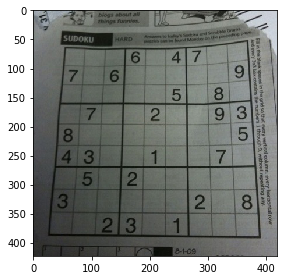

The hsv conversion by custom function:


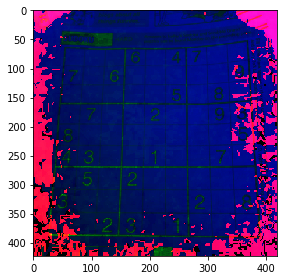

The hsv conversion by skimage function:


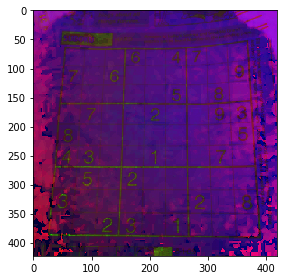

In [5]:
my_converter = VDImageConverter(image0);

image1 = my_converter.hsv_that_rgb();
image2 = color.rgb2hsv(image0);

print("The original:");
io.imshow(image0);
io.show();

print("The hsv conversion by custom function:");
io.imshow(image1);
io.show();

print("The hsv conversion by skimage function:");
io.imshow(image2);
io.show();

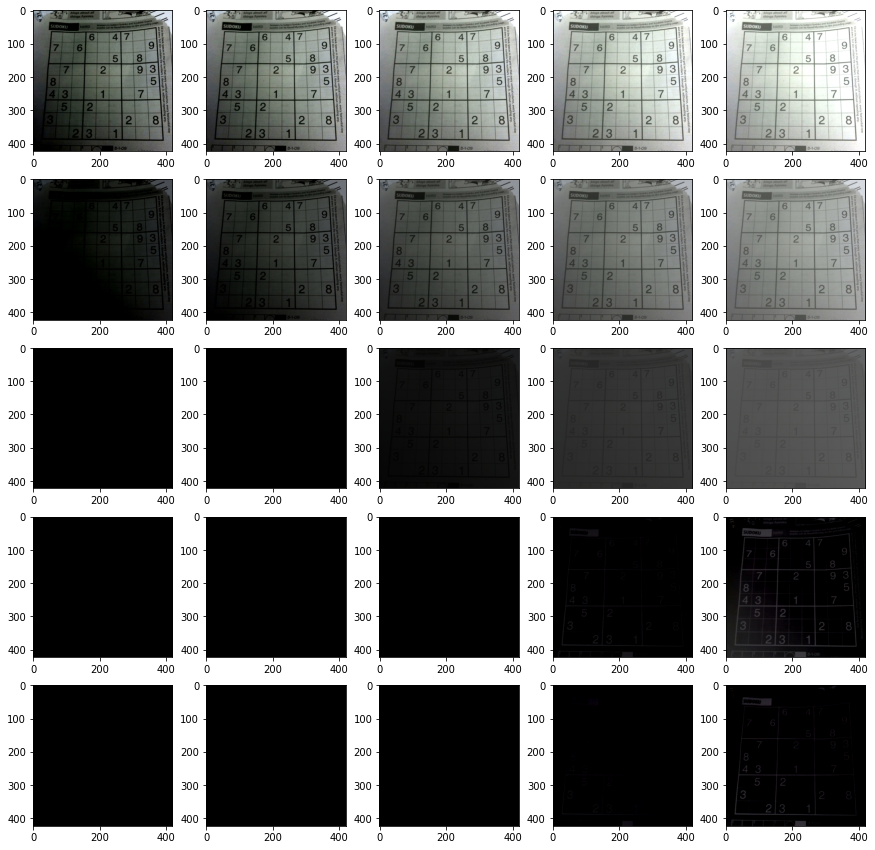

In [6]:
# Tuple of tuples of tuples with the test cases.
# 3D Tuple.
# Each pair of values contains: Brightness, Contrast.
# I've chosen to put 1 for contrast instead of 0 because 0 gives black.
test_cases = (((10, -10), (10, -5), (10, 0), (10, 5), (10, 10)),
              ((5, -10), (5, -5), (5, 0), (5, 5), (5, 10)),
              ((1, -10), (1, -5), (1, 0), (1, 5), (1, 10)),
              ((-5, -10), (-5, -5), (-5, 0), (-5, 5), (-5, 10)),
              ((-10, -10), (-10, -5), (-10, 0), (-10, 5), (-10, 10)));

fig0, axs1 = plt.subplots(nrows=5, ncols=5, figsize=(15, 15));

# I've chosen to add these factors in order to get some better visual results.
c_factor = 1/7;
b_factor = 7;

for i in range(5):
    for j in range(5):
        axs1[i][j].imshow(my_converter.change_c_and_b(c_factor*test_cases[i][j][0], b_factor*test_cases[i][j][1]));
    
plt.show();

The percentages returned by structural similarity are the following:
1.0
0.9812940261700773
0.9568433177070895
1.0


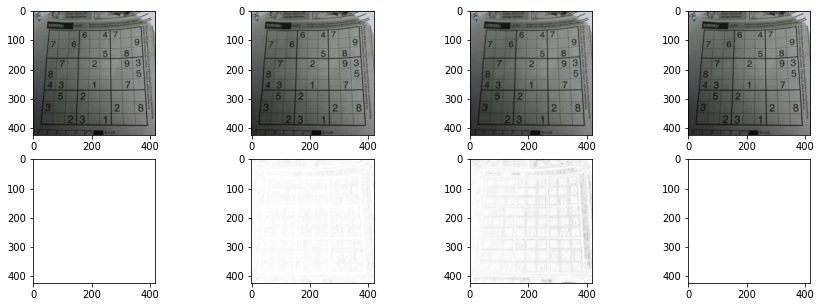

In [41]:
fig1, axs1 = plt.subplots(nrows=2, ncols=4, figsize=(15, 5));

med_blur_image = np.copy(image0);
cv2.medianBlur(src=image0, dst=med_blur_image, ksize=3);

gauss_blur_image = np.copy(image0);
cv2.GaussianBlur(src=image0, dst=gauss_blur_image, ksize=(3, 3), sigmaX=0);

bi_blur_image = np.copy(image0);
cv2.bilateralFilter(src=image0, dst=med_blur_image, d=3, sigmaColor=75, sigmaSpace=75);

axs1[0][0].imshow(image0);
axs1[0][1].imshow(med_blur_image);
axs1[0][2].imshow(gauss_blur_image);
axs1[0][3].imshow(bi_blur_image);

mssim0, grad0, fullIm0 = ssim(image0, 
                              image0, 
                              data_range=image0.max() - image0.min(), 
                              multichannel=True,
                              gradient=True,
                              full=True);

mssim1, grad1, fullIm1 = ssim(image0, 
                              med_blur_image, 
                              data_range=med_blur_image.max() - med_blur_image.min(), 
                              multichannel=True,
                              gradient=True,
                              full=True);

mssim2, grad2, fullIm2 = ssim(image0, 
                              gauss_blur_image, 
                              data_range=gauss_blur_image.max() - gauss_blur_image.min(), 
                              multichannel=True,
                              gradient=True,
                              full=True);

mssim3, grad3, fullIm3 = ssim(image0, 
                              bi_blur_image, 
                              data_range=bi_blur_image.max() - bi_blur_image.min(), 
                              multichannel=True,
                              gradient=True,
                              full=True);

axs1[1][0].imshow(fullIm0);
axs1[1][1].imshow(fullIm1);
axs1[1][2].imshow(fullIm2);
axs1[1][3].imshow(fullIm3);

print("The percentages returned by structural similarity are the following:");
print(mssim0);
print(mssim1)
print(mssim2)
print(mssim3)

plt.show()